In [53]:
import pandas as pd
import numpy as np
import os
import sys
import matplotlib.pyplot as plt
import seaborn as sns
import utils

import sklearn
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_validate
from sklearn.metrics import roc_curve,auc

from mlxtend.feature_selection import SequentialFeatureSelector
from mlxtend.plotting import plot_sequential_feature_selection

### Overview

This notebook uses the datafiles generated from the preprocessing notebook. The purpose of this notebook is to explore the best model generated - classification on 2 day features

11. Replicate best classification model with python
12. Model Diagnostics via learning curve
13. Build Simpler Random Forest Model
14. Simplify model additionally with Sequential Feature Selector
15. Predict on Testing set


## 11. Use python to replicate best model for best features set - classification for 2day model

Focus on the best model (day 2 model) and how to improve it

#### replicate best nontime model with sklearn - using hyper parameters extracted from dataiku

In [2]:
df_train_nontime = pd.read_csv('data/df_train_nontime.csv')
df_train_1day = pd.read_csv('data/df_train_1day.csv')
df_train_2day = pd.read_csv('data/df_train_2day.csv')

Hyper parameters determined from Dataiku

In [3]:
pipeline = Pipeline(steps =[('imputer', SimpleImputer()), ('rf', RandomForestClassifier(n_estimators = 100, max_depth = 6, min_samples_leaf = 6))])

In [4]:
X_train_2day = df_train_2day.drop(['Length_of_stay','Above_2_weeks'],axis = 1)
y_train_2day = df_train_2day['Above_2_weeks']

In [5]:
cv = StratifiedKFold(n_splits = 5, shuffle = True,)
cv_results = cross_validate(pipeline, X_train_2day, y_train_2day, cv = cv, scoring = ['roc_auc'], return_train_score = True)

In [6]:
cv_results

{'fit_time': array([0.50623608, 0.49558783, 0.50105214, 0.48776221, 0.50485921]),
 'score_time': array([0.01378798, 0.01553512, 0.01610613, 0.01438808, 0.01397872]),
 'test_roc_auc': array([0.68163017, 0.69321914, 0.72059593, 0.73434122, 0.69439493]),
 'train_roc_auc': array([0.85056836, 0.85893026, 0.84801474, 0.85183446, 0.85299527])}

### baseline results

In [7]:
print('test 5 fold cv rocauc is {:.3f}'.format(np.mean(cv_results['test_roc_auc'])))
print('train 5 fold cv rocauc is {:.3f}'.format(np.mean(cv_results['train_roc_auc'])))

test 5 fold cv rocauc is 0.705
train 5 fold cv rocauc is 0.852


## 12. Model Diagnostics via learning curve

https://scikit-learn.org/stable/auto_examples/model_selection/plot_learning_curve.html

<module 'matplotlib.pyplot' from '/Users/x006814/Documents/venvs/axiom_virtualenv/lib/python3.7/site-packages/matplotlib/pyplot.py'>

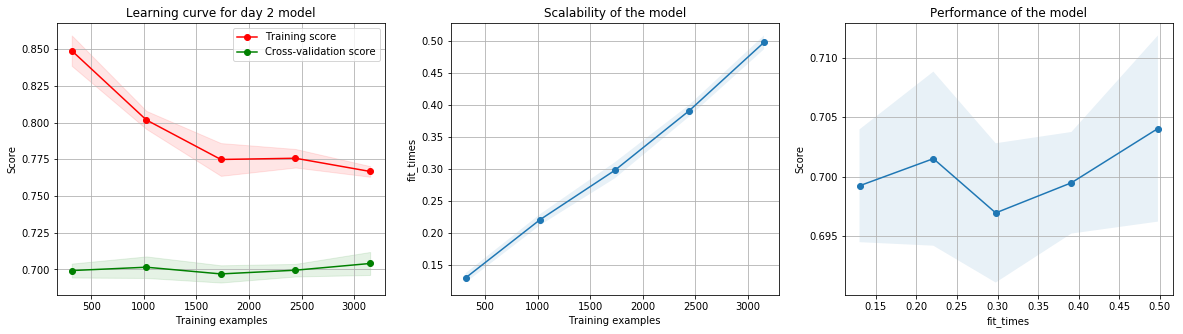

In [8]:
utils.plot_learning_curve(pipeline, 'Learning curve for day 2 model', X_train_2day, y_train_2day, cv=cv, train_sizes=np.linspace(.1, 1.0, 5))

## Discussion

* Model is slightly overfit as there is a gap between training and testing performance
* Model is seeing an performance boost with more data so more data could benefit the model
* Model could benefit from being simpler (less trees) closer training/testing scores

### 13. Use a simpler random forest

* 100 estimators to 20 
* 6 max depth to 4

In [9]:
pipeline_simple = Pipeline(steps =[('imputer', SimpleImputer()), ('rf', RandomForestClassifier(n_estimators = 20, max_depth = 4, min_samples_leaf = 6))])

In [10]:
cv = StratifiedKFold(n_splits = 5, shuffle = True,)

cv_results = cross_validate(pipeline_simple, X_train_2day, y_train_2day, cv = cv, scoring = ['roc_auc'], return_train_score = True)

In [11]:
cv_results

{'fit_time': array([0.08768582, 0.08067894, 0.08141804, 0.07561517, 0.07099271]),
 'score_time': array([0.00500607, 0.00447512, 0.00469804, 0.00418878, 0.00415111]),
 'test_roc_auc': array([0.68947308, 0.70387705, 0.71169411, 0.67777087, 0.69123928]),
 'train_roc_auc': array([0.76880044, 0.76476525, 0.76303874, 0.77096376, 0.7614498 ])}

In [12]:
print('test 5 fold cv rocauc is {:.3f}'.format(np.mean(cv_results['test_roc_auc'])))
print('train 5 fold cv rocauc is {:.3f}'.format(np.mean(cv_results['train_roc_auc'])))

test 5 fold cv rocauc is 0.695
train 5 fold cv rocauc is 0.766


<module 'matplotlib.pyplot' from '/Users/x006814/Documents/venvs/axiom_virtualenv/lib/python3.7/site-packages/matplotlib/pyplot.py'>

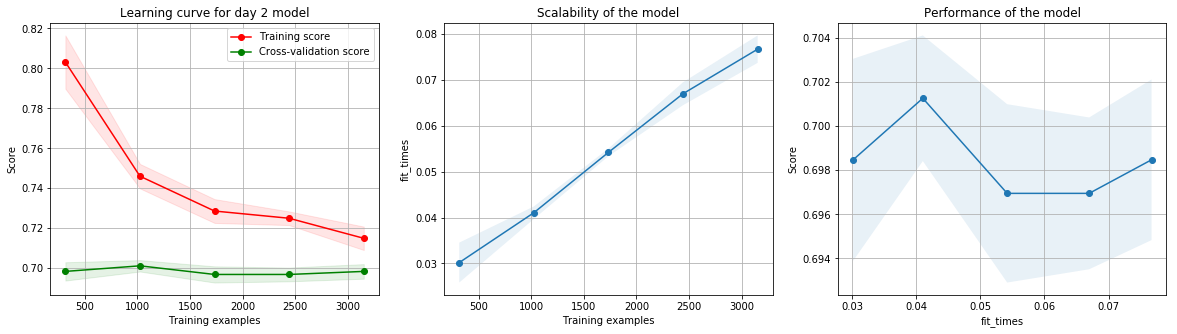

In [13]:
utils.plot_learning_curve(pipeline_simple, 'Learning curve for day 2 model', X_train_2day, y_train_2day, cv=cv, train_sizes=np.linspace(.1, 1.0, 5))

### These results show less overfitting

## 13. Simplify model additionally with Sequential Feature Selector

Forward feature selection via greedy search

In [14]:
pipeline_simple_sfs = Pipeline(steps =[('imputer', SimpleImputer()), 
                                       ('rf', RandomForestClassifier(n_estimators = 20, max_depth = 4, min_samples_leaf = 6))])
cv = StratifiedKFold(n_splits = 5, shuffle = True,)

sfs = SequentialFeatureSelector(pipeline_simple_sfs, 
                                   k_features=20, 
                                   forward=True, 
                                   verbose=2,
                                   scoring='roc_auc',
                                   cv=5,
                                   n_jobs = 4)

In [15]:
sfs = sfs.fit(X_train_2day, y_train_2day)

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  28 out of  28 | elapsed:    2.9s finished

[2020-07-26 15:14:57] Features: 1/20 -- score: 0.6365271698586403[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  27 out of  27 | elapsed:    2.7s finished

[2020-07-26 15:15:00] Features: 2/20 -- score: 0.6723456723190185[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  26 out of  26 | elapsed:    2.7s finished

[2020-07-26 15:15:03] Features: 3/20 -- score: 0.6806282421136365[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  25 out of  25 | elapsed:    2.9s finished

[2020-07-26 15:15:06] Features: 4/20 -- score: 0.6853182410686649[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  24 out of  24 | elapsed:    2.7s finished

[2020-07-2

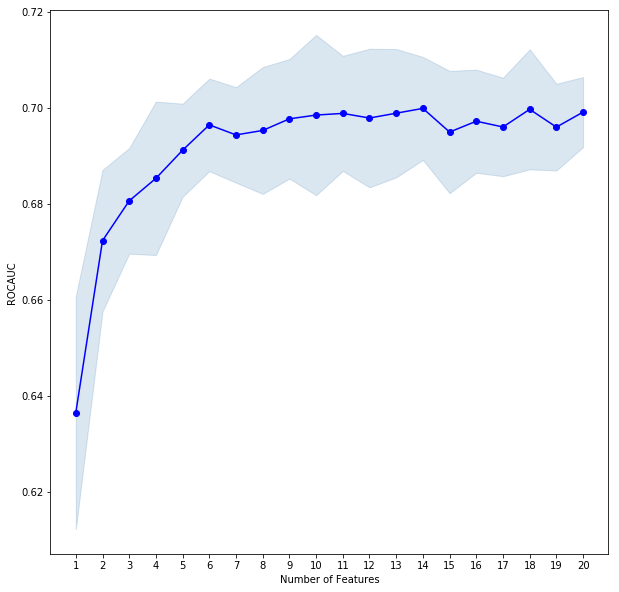

In [16]:
f = plot_sequential_feature_selection(sfs.get_metric_dict(), figsize = (10,10),ylabel = 'ROCAUC')
plt.savefig('img/sfs_2day_results.png')

In [19]:
total_cols = list(X_train_2day.columns)

In [20]:
output_dict = sfs.get_metric_dict()

for key,value in output_dict.items():
    col_name = [total_cols[idx] for idx in value['feature_idx']]
    roc_auc =value['avg_score']
    print(f'{key} - auc = {roc_auc:.3f} - {col_name}')

1 - auc = 0.637 - ['GCS']
2 - auc = 0.672 - ['GCS', 'ICUType']
3 - auc = 0.681 - ['NISysABP', 'GCS', 'ICUType']
4 - auc = 0.685 - ['NISysABP', 'GCS', 'BUN', 'ICUType']
5 - auc = 0.691 - ['MAP', 'NISysABP', 'GCS', 'BUN', 'ICUType']
6 - auc = 0.696 - ['MAP', 'NISysABP', 'HR', 'GCS', 'BUN', 'ICUType']
7 - auc = 0.694 - ['MAP', 'NISysABP', 'HR', 'GCS', 'HCT', 'BUN', 'ICUType']
8 - auc = 0.695 - ['MAP', 'pH', 'NISysABP', 'HR', 'GCS', 'HCT', 'BUN', 'ICUType']
9 - auc = 0.698 - ['MAP', 'pH', 'NISysABP', 'HR', 'GCS', 'HCT', 'BUN', 'Age', 'ICUType']
10 - auc = 0.698 - ['MAP', 'pH', 'NISysABP', 'HR', 'GCS', 'HCO3', 'HCT', 'BUN', 'Age', 'ICUType']
11 - auc = 0.699 - ['MAP', 'pH', 'NIDiasABP', 'NISysABP', 'HR', 'GCS', 'HCO3', 'HCT', 'BUN', 'Age', 'ICUType']
12 - auc = 0.698 - ['MAP', 'pH', 'NIDiasABP', 'NISysABP', 'HR', 'GCS', 'HCO3', 'WBC', 'HCT', 'BUN', 'Age', 'ICUType']
13 - auc = 0.699 - ['MAP', 'pH', 'NIDiasABP', 'NISysABP', 'Glucose', 'HR', 'GCS', 'HCO3', 'WBC', 'HCT', 'BUN', 'Age', 'ICUType

## At 14 features the model stagnates around .7 AUC

In [22]:
sfs_feature_list = ['MAP', 'pH', 'NIDiasABP', 'NISysABP', 'Glucose', 'HR', 'GCS', 'Mg', 'HCO3', 'WBC', 'HCT', 'BUN', 'Age', 'ICUType']

X_sfs_train = X_train_2day[sfs_feature_list]

In [ ]:
pipeline_simple_sfs = Pipeline(steps =[('imputer', SimpleImputer()), 
                                       ('rf', RandomForestClassifier(n_estimators = 20, max_depth = 4, min_samples_leaf = 6))])



In [24]:
cv = StratifiedKFold(n_splits = 5, shuffle = True,)

cv_results_sfs = cross_validate(pipeline_simple_sfs, X_sfs_train , y_train_2day, cv = cv, scoring = ['roc_auc'], return_train_score = True)

In [28]:
cv_results_sfs

{'fit_time': array([0.08218765, 0.05801296, 0.05659795, 0.06422997, 0.05667305]),
 'score_time': array([0.0054512 , 0.0042901 , 0.00431728, 0.00544834, 0.00396204]),
 'test_roc_auc': array([0.69390967, 0.68506072, 0.6734015 , 0.69284744, 0.69428493]),
 'train_roc_auc': array([0.755145  , 0.75599535, 0.75925151, 0.75886489, 0.75633549])}

In [29]:
print('test 5 fold cv rocauc is {:.3f}'.format(np.mean(cv_results_sfs['test_roc_auc'])))
print('train 5 fold cv rocauc is {:.3f}'.format(np.mean(cv_results_sfs['train_roc_auc'])))

test 5 fold cv rocauc is 0.688
train 5 fold cv rocauc is 0.757


<module 'matplotlib.pyplot' from '/Users/x006814/Documents/venvs/axiom_virtualenv/lib/python3.7/site-packages/matplotlib/pyplot.py'>

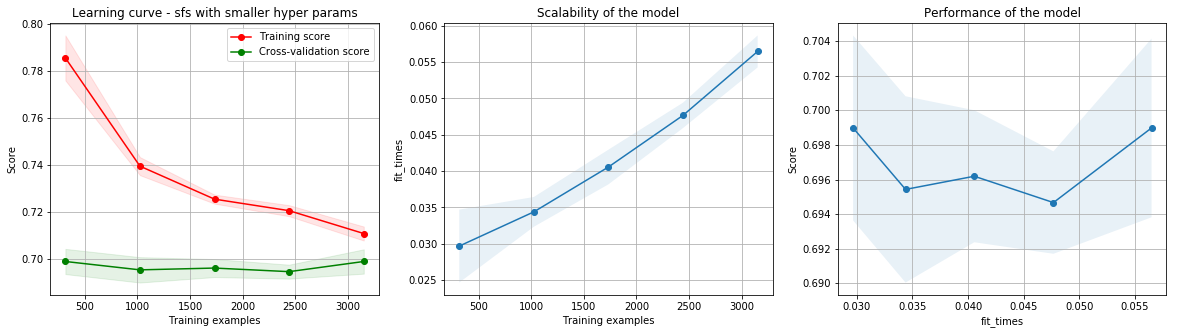

In [30]:
utils.plot_learning_curve(pipeline_simple_sfs, 'Learning curve - sfs with smaller hyper params', X_sfs_train, y_train_2day, cv=cv, train_sizes=np.linspace(.1, 1.0, 5))

## 15. Predict on Testing set


In [31]:
df_test_2day = pd.read_csv('data/df_test_2day.csv')

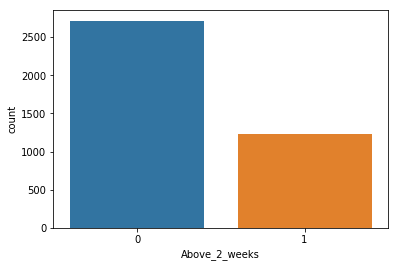

In [34]:
sns.countplot(df_test_2day['Above_2_weeks'])

In [36]:
X_test_sfs = df_test_2day[sfs_feature_list]

y_test = df_test_2day['Above_2_weeks']

In [37]:
pipeline_simple_sfs.fit(X_sfs_train , y_train_2day)

Pipeline(memory=None,
         steps=[('imputer',
                 SimpleImputer(add_indicator=False, copy=True, fill_value=None,
                               missing_values=nan, strategy='mean',
                               verbose=0)),
                ('rf',
                 RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                        class_weight=None, criterion='gini',
                                        max_depth=4, max_features='auto',
                                        max_leaf_nodes=None, max_samples=None,
                                        min_impurity_decrease=0.0,
                                        min_impurity_split=None,
                                        min_samples_leaf=6, min_samples_split=2,
                                        min_weight_fraction_leaf=0.0,
                                        n_estimators=20, n_jobs=None,
                                        oob_score=False, random_state=None,
     

In [49]:
y_pred_proba = pipeline_simple_sfs.predict_proba(X_test_sfs)[:,1]

Text(0.5, 1.0, 'predicted probability histogram')

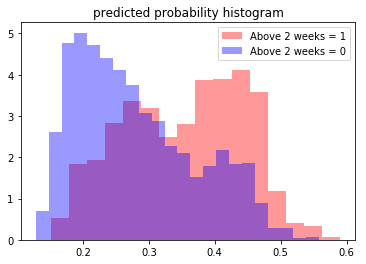

In [56]:
sns.distplot(y_pred_proba[y_test==1], color = 'red', kde = False, norm_hist = True)
sns.distplot(y_pred_proba[y_test==0], color = 'blue', kde = False, norm_hist = True)
plt.legend(['Above 2 weeks = 1','Above 2 weeks = 0'])
plt.title('predicted probability histogram')

In [57]:
def plot_roc(fpr,tpr):
    roc_auc = auc(fpr,tpr)

    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',
             lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc="lower right")
    plt.show()

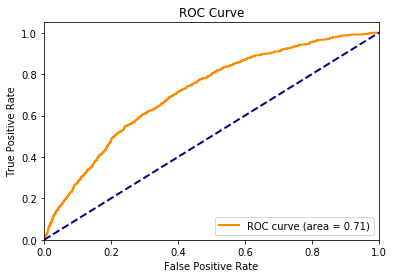

In [58]:
fpr, tpr, thres = roc_curve(y_test,y_pred_proba)
plot_roc(fpr,tpr)

## Results generalize to the testing set